In [76]:
import numpy as np
import pandas as pd
import random as rd
import math as m
import csv
from matplotlib import pyplot as plt
import warnings
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture


In [77]:
# Default parameters
no_of_device = 10
sub_channel = int(no_of_device / 2)
radius = 200
altitude = 100
carrier_frequency = 1 * (10 ** 9)
bandwidth = 1 * (10 ** 6)
alpha = 2 * (10 ** (-28))
mu = (10 ** 3)
eta = 3.76
task_offloading_bits = int(2 * (10 ** 1))
# Task_Offloading_Bits = int(100)
error_propagation = 10 ** (-6)
max_execution_time = 0.01

In [78]:
# Defining the noise power
def noise_power(bandwidth):
    noise_power_dBm = -174 + 10 * np.log10(bandwidth)
    noise_power = (10 ** (-3)) * (10 ** (noise_power_dBm / 10))
    return noise_power

In [79]:

# Calculating the transmitting power
def tx_power(tx):
    tx_power = (10 ** (-3)) * (10 ** (tx / 10))
    return tx_power

In [80]:
# Base Station Location
for i in range(1):
    base_station =[]
    np.random.seed(i)
    arg  = 2 * np.pi * np.random.random(2)
    base_station.append(arg)
base_station = np.array(base_station)
# print(base_station)


In [81]:
# Device Location w.r.t ground
device_loc =[]
for i in range(no_of_device):
    np.random.seed(i)
    arg = 2 * np.pi * np.random.random(1)
    np.random.seed(i)
    device_r = radius * np.sqrt(np.random.random(1))
    device_x = device_r * np.cos(arg)
    device_y = device_r * np.sin(arg)
    device_loc.append(device_x)
    device_loc.append(device_y)
    device_loc.append(device_r)
device_loc = np.array(device_loc).reshape(no_of_device,3)
# print(device_loc)

# updating device radius w.r.t. the ground base station
for i in range(no_of_device):
    x_axis = device_loc[i][0] - base_station[0][0]
    y_axis = device_loc[i][1] - base_station[0][1]
    distance = np.sqrt(np.square(x_axis) + np.square(y_axis))
    device_loc[i][2] = distance
    # print(x_axis)
    # print(y_axis)
    # print(distance)
# print(device_loc)

# device location w.r.t altitude
for i in range(no_of_device):
    device_loc[i][2] = np.sqrt(np.square(altitude) + np.square(device_loc[i][2]))
# print(device_loc)



In [82]:

# Creating a dataframe 
columns = ['device_x','device_y','device_r']
dataset = pd.DataFrame(device_loc,columns=columns)
for i in range(no_of_device):
    dataset['base_station_x'] = base_station[0][0]
    dataset['base_station_y'] = base_station[0][1]
dataset = dataset[['base_station_x','base_station_y','device_x','device_y','device_r']]

# Saving the clustering dataframe
# print(dataset.head())
dataset.to_csv('bs_device_dataset.csv',index=False)

In [83]:
# Fading for each bit transmitted i.e. [no of device * task offloading bits]
channel_gain =[]
abs_channel_gain =[]
for i in range(no_of_device):
    np.random.seed(i)
    channel = np.sqrt(dataset['device_r'][i] ** (-eta)) * (np.random.randn(task_offloading_bits,1) + 1j * np.random.randn(task_offloading_bits,1))
    channel_gain.append(channel)
    abs_channel_gain.append(np.abs(channel)**2)
channel_gain= np.array(channel_gain).reshape(no_of_device,task_offloading_bits)
abs_channel_gain = np.array(abs_channel_gain).reshape(no_of_device,task_offloading_bits)
abs_channel_gain = np.mean(abs_channel_gain,axis=1)
# print(abs_channel_gain)
# channel_gain_df.columns =['channel_gain']
# dataset = pd.concat([dataset, channel_gain_df],axis=1)
# print(channel_gain_df.head())
# print(channel_gain)
# print(np.shape(channel_gain))
# print(channel_gain[0])
# print(channel_gain[0][0])
# print(abs_channel_gain[0])



In [84]:
print(abs_channel_gain)
print(abs_channel_gain[0])

[7.71655279e-09 8.81659841e-09 9.82297959e-09 6.44932187e-09
 3.38297846e-09 1.62936013e-08 3.93025252e-09 4.55521668e-08
 4.21611718e-09 6.27472986e-08]
7.716552789096617e-09


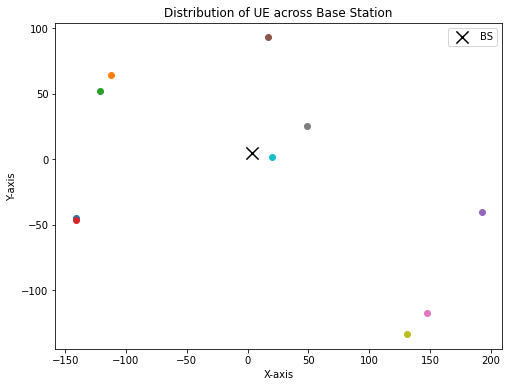

<Figure size 432x288 with 0 Axes>

In [85]:
# Distributions of UE across the base station
# print(dataset[['device_x','device_y']])
plt.figure(figsize=(8,6))
for i in range(no_of_device):
    plt.scatter(dataset['device_x'][i],dataset['device_y'][i])
plt.scatter(dataset['base_station_x'][0],dataset['base_station_y'][0],s=150,c='black',marker='x',label='BS')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Distribution of UE across Base Station')
plt.legend()
plt.show()
plt.savefig('user_distribution.png')

In [86]:
print(dataset)
print(dataset['device_r'][9])
# print(dataset.sort_values(by='device_r'))

   base_station_x  base_station_y    device_x    device_y    device_r
0        3.448297        4.493667 -141.249647  -44.733402  182.649389
1        3.448297        4.493667 -111.994962   64.327355  164.034192
2        3.448297        4.493667 -121.523997   51.688629  166.869525
3        3.448297        4.493667 -140.935039  -46.575004  182.905869
4        3.448297        4.493667  192.470330  -40.452016  218.516460
5        3.448297        4.493667   16.496807   92.777057  134.030670
6        3.448297        4.493667  147.754738 -117.825903  213.977630
7        3.448297        4.493667   49.018408   25.485825  111.880765
8        3.448297        4.493667  130.858084 -133.466618  212.758770
9        3.448297        4.493667   20.327458    1.326879  101.463957
101.46395727274688


In [87]:
# Near Far Pairing of Users
dataset_nf_asc = dataset.sort_values(by='device_r')
# print(dataset_nf_asc)
# print(dataset_nf_asc.index)
# print(dataset_nf_asc.index[0])
# print(dataset_nf_asc[9])
# print(dataset_nf_asc[dataset_nf_asc.index[0]])
# near_far_pairing = np.zeros((no_of_device,1))
# for i in range(no_of_device):
#     near_far_pairing[i] = dataset_nf_asc.iloc[i]
#     near_far_pairing[i+1] = dataset_nf_asc.iloc[no_of_device - (i+1)]
# print(near_far_pairing)
# print(dataset_nf_asc)
# Random Pairing of Users
np.random.seed(no_of_device)
random_pairing = np.random.permutation(np.arange(0,no_of_device))



In [88]:
np.random.seed(1)
n = np.random.permutation(np.arange(0,no_of_device))
print(n)
print(n[1])

[2 9 6 4 0 3 1 7 8 5]
9


In [89]:
random_pairing.shape


(10,)

In [90]:
# NOMA Power Allocation for paired users
ue_power = np.zeros((no_of_device,1))
def noma_ue_fixed_power(no_of_device,dataset_nf_asc):
    for i in range(int(no_of_device)):
        if(dataset_nf_asc.iloc[i]['device_r'] > dataset_nf_asc.iloc[no_of_device - (i+1)]['device_r']):
            ue_power[i] = 0.75
            ue_power[no_of_device - (i+1)] = 0.25
        else:
            ue_power[i] = 0.25
            ue_power[no_of_device - (i+1)] = 0.75
    return ue_power
def noma_ue_fixed_power_rd(no_of_device,dataset_nf_asc,rd):
    for i in range(int(no_of_device/2)):
        if(dataset_nf_asc.iloc[rd[i]]['device_r'] > dataset_nf_asc.iloc[rd[i+1]]['device_r']):
            ue_power[i] = 0.75
            ue_power[i+1] = 0.25
        else:
            ue_power[i] = 0.25
            ue_power[i+1] = 0.75
    return ue_power

In [110]:
# NOMA power for NF user
noma_power_nf = noma_ue_fixed_power(no_of_device=no_of_device,dataset_nf_asc=dataset_nf_asc)
print(noma_power_nf)

# NOMA power for RP user
print(random_pairing)
noma_power_rp = noma_ue_fixed_power_rd(no_of_device=no_of_device,dataset_nf_asc=dataset_nf_asc, rd=random_pairing)
print(noma_power_rp)
# print(dataset_nf_asc)
print(noma_power_nf)


[[0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.75]
 [0.75]
 [0.75]
 [0.75]
 [0.75]]
[8 2 5 6 3 1 0 7 4 9]
[[0.75]
 [0.25]
 [0.25]
 [0.75]
 [0.75]
 [0.25]
 [0.75]
 [0.75]
 [0.75]
 [0.75]]
[[0.75]
 [0.25]
 [0.25]
 [0.75]
 [0.75]
 [0.25]
 [0.75]
 [0.75]
 [0.75]
 [0.75]]


In [104]:
def fun(x):
    return x * x

In [93]:
print(noma_power_nf)
# print(noma_power_rp)

[[0.75]
 [0.25]
 [0.25]
 [0.75]
 [0.75]
 [0.25]
 [0.75]
 [0.75]
 [0.75]
 [0.75]]


In [94]:
bandwidth = bandwidth/(int(no_of_device/2))

In [95]:
# Calculation of Capacity
def capacity_fn(no_of_device,abs_channel_gain,ue_power,error_propagation,bandwidth):
    rate = []
    capacity =[]
    for i,snr in enumerate(range(0,30,3)):
        for j in range(no_of_device):
            gamma = tx_power(snr) * abs_channel_gain[i]
            cap = bandwidth * np.log2(1 + ((gamma * ue_power[j])/((error_propagation * gamma * ue_power[no_of_device -(j+1)]) + noise_power(bandwidth) )))
            capacity.append(cap)
        rate.append(np.mean(capacity))
    rate = np.array(rate).reshape(len(range(0,30,3)))
    return rate

# print(capacity)
# print(np.shape(rate))
# print(rate)

In [96]:
# For NF pairing, Calculating the capacity for no_of_device = 10
print(noma_power_nf)
capacity_nf = capacity_fn(no_of_device,abs_channel_gain,ue_power=noma_power_nf,error_propagation=error_propagation,bandwidth=bandwidth);
print(capacity_nf)

# For RP pairing, Calculating the capacity for no_of_device = 10
print(noma_power_rp)
capacity_rp = capacity_fn(no_of_device=no_of_device,abs_channel_gain=abs_channel_gain,
                          ue_power=noma_power_rp,error_propagation=error_propagation,bandwidth=bandwidth);
print(capacity_rp)

[[0.75]
 [0.25]
 [0.25]
 [0.75]
 [0.75]
 [0.25]
 [0.75]
 [0.75]
 [0.75]
 [0.75]]
[2468788.79169281 2586593.40350097 2701168.80024735 2777299.71964491
 2825507.83175166 2952879.97460901 3020002.22643699 3131723.66523301
 3197744.47418929 3275095.83052162]
[[0.75]
 [0.25]
 [0.25]
 [0.75]
 [0.75]
 [0.25]
 [0.75]
 [0.75]
 [0.75]
 [0.75]]
[2468788.79169281 2586593.40350097 2701168.80024735 2777299.71964491
 2825507.83175166 2952879.97460901 3020002.22643699 3131723.66523301
 3197744.47418929 3275095.83052162]


In [97]:
# # Generating Random Bits for all devices
# bit_generation = np.zeros((no_of_device,task_offloading_bits))
# for i in range(no_of_device):
#     for j in range(task_offloading_bits):
#         rd.seed(i+j)
#         bit_generation[i][j] = rd.randint(0,1)
# # print(bit_generation)
# # print(bit_generation[0])
# # print(bit_generation[1])
# # print(bit_generation[5][0])


In [98]:
# # Modulation  - BPSK
# mod_bit =np.zeros((no_of_device,task_offloading_bits))
# for i in range(no_of_device):
#     for j in range(task_offloading_bits):
#         mod_bit[i][j] = (2 * bit_generation[i][j]) - 1
# # print(mod_bit)
# # print(mod_bit[0])
# # print(mod_bit[3][2])

In [99]:
# # Find the optimum number of cluster
# sse  =[]
# silh_score =[]
# for k in range(2,(int(no_of_device/2)+ 1)):
#     km = KMeans(n_clusters=k, random_state=0,init='k-means++',n_init='auto')
#     km.fit(dataset.drop(columns=['channel_gain']))
#     label = km.labels_
#     sil_score = silhouette_score(dataset.drop(columns=['channel_gain']),label)
#     # dataset['Cluster'] = label
#     sse.append(km.inertia_)
#     silh_score.append(sil_score)
    

In [100]:
# # Forming N/2 or N/2 + 1 Cluster
# # k-mean clustering
# # sse =[]
# km = KMeans(n_clusters=int(no_of_device/2),random_state=0, init='k-means++',n_init='auto')
# km.fit(dataset.drop(columns=['channel_gain']))
# dataset['kcluster'] =km.labels_

# #dbscan clustering
# # label with -1 are outliers so will be considered as signel user
# dbscan = DBSCAN(eps=50,min_samples=2, algorithm='auto')
# dbscan.fit(dataset.drop(columns=['channel_gain']))
# dataset['dbcluster'] =dbscan.labels_

# #gmm clustering
# gmm = GaussianMixture(n_components=int(no_of_device/2),covariance_type='full',init_params ='k-means++',random_state=0)
# gmm.fit(dataset.drop(columns=['channel_gain']))
# dataset['gmmcluster'] = gmm.predict(dataset.drop(columns=['channel_gain']))



In [101]:
# # K Mean Clustering Plot
# km = KMeans(n_clusters=20,random_state=0, init='k-means++',n_init='auto')
# km.fit(dataset[['device_x','device_y']])
# centroids = km.cluster_centers_
# plt.figure(figsize=(8,6))
# for i in range(no_of_device):
#     plt.scatter(dataset['device_x'][i],dataset['device_y'][i])
# plt.scatter(centroids[:,0],centroids[:,1],s=200,c='black',marker='x',label='Centroids')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('K-Mean Clustering')
# plt.legend()
# plt.show()

In [102]:
# # Elbow Method and Silhoutte Score Plot
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.plot(range(2,(int(no_of_device/2)+ 1)),sse)
# plt.xticks(np.arange(2,(int(no_of_device/2)+ 1),50))
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Cluster')
# plt.savefig('Elbow.png')

# plt.subplot(1,2,2)
# plt.plot(range(2,(int(no_of_device/2)+ 1)),silh_score)
# plt.xticks(np.arange(2,(int(no_of_device/2)+ 1),50))
# plt.xlabel('Number of Clusters')
# plt.ylabel('silhouette_score')
# plt.title('silhouette Score for Cluster')
# plt.savefig('silhouette_score.png')
# plt.show()

In [103]:
# # UE Locations
# lambdaB = 10 ** (-7)
# areaTotal = np.pi * (10000)**2
# numbPoints = 1 + np.random.poisson(areaTotal * lambdaB)
# theta = 2 * np.pi * np.random.rand(numbPoints)
# rho = 1 + (10000 - 1) * np.sqrt(np.random.rand(numbPoints))
# xx, yy = pol2cart(theta, rho)
# print(xx,yy)
# points=1
# lambdaB1 = np.logspace(-7, -5, points)
# print(lambdaB1)
